# Setup


You can run the following command to install all the requirements:

`> pip install torch torchvision numpy matplotlib git+https://github.com/AMLab-Amsterdam/lie_learn escnn scipy`

In [ ]:
import torch
import numpy as np
import scipy
import os

np.set_printoptions(precision=3, suppress=True, linewidth=10000, threshold=100000)

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# If the fonts in the plots are incorrectly rendered, comment out the next two lines
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
matplotlib.rcParams['lines.linewidth'] = 2.0

import urllib.request
from urllib.error import HTTPError

CHECKPOINT_PATH = "../../saved_models/DL2/GDL"

<ipython-input-2-433ef526a958>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [ ]:
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)


# Files to download
pretrained_files = [
    "steerable_c4-pretrained.ckpt",
    "steerable_so2-pretrained.ckpt",
    "steerable_c4-accuracies.npy",
    "steerable_so2-accuracies.npy",
]

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/DL2/GDL/"

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please contact the author with the full output including the following error:\n", e)

In [ ]:
try:
    from escnn.group import *
except ModuleNotFoundError: # Google Colab does not have escnn installed by default. Hence, we do it here if necessary
    !pip install --quiet git+https://github.com/AMLab-Amsterdam/lie_learn escnn
    from escnn.group import *

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.9/373.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 38.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart

In [ ]:
from escnn import group
from escnn import gspaces
from escnn import nn

In [ ]:
#the group of 4 rotations G=C4
r2_act = gspaces.rot2dOnR2(N=4)
r2_act
G = r2_act.fibergroup
G

C4_on_R2[(None, 4)]

In [ ]:
#the group of all planar rotations G=SO(2)
r2_act = gspaces.rot2dOnR2(N=-1)
r2_act
G = r2_act.fibergroup
G

# Build and Train Steerable CNNs

### Dataset

In [ ]:
# download the dataset
!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist.zip
# uncompress the zip file
!unzip -n mnist.zip -d mnist

--2024-01-24 11:41:05--  http://www.iro.umontreal.ca/~lisa/icml2007data/mnist.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23653151 (23M) [application/zip]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  22.56M  22.5MB/s    in 1.0s    

2024-01-24 11:41:06 (22.5 MB/s) - ‘mnist.zip’ saved [23653151/23653151]

Archive:  mnist.zip
  inflating: mnist/mnist_train.amat  
  inflating: mnist/mnist_test.amat   


In [ ]:
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from tqdm.auto import tqdm

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class MnistDataset(Dataset):

    def __init__(self, mode, rotated: bool = True):
        assert mode in ['train', 'test']

        if mode == "train":
            file = "mnist/mnist_train.amat"
        else:
            file = "mnist/mnist_test.amat"

        data = np.loadtxt(file)

        images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)

        # images are padded to have shape 29x29.
        # this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
        pad = Pad((0, 0, 1, 1), fill=0)

        # to reduce interpolation artifacts (e.g. when testing the model on rotated images),
        # we upsample an image by a factor of 3, rotate it and finally downsample it again
        resize1 = Resize(87) # to upsample
        resize2 = Resize(29) # to downsample

        totensor = ToTensor()

        if rotated:
            self.images = torch.empty((images.shape[0], 1, 29, 29))
            for i in tqdm(range(images.shape[0]), leave=False):
                img = images[i]
                img = Image.fromarray(img, mode='F')
                r = (np.random.rand() * 360.)
                self.images[i] = totensor(resize2(resize1(pad(img)).rotate(r, Image.BILINEAR))).reshape(1, 29, 29)
        else:
            self.images = torch.zeros((images.shape[0], 1, 29, 29))
            self.images[:, :, :28, :28] = torch.tensor(images).reshape(-1, 1, 28, 28)

        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)

    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]

        return image, label

    def __len__(self):
        return len(self.labels)


In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

# build the rotated training and test datasets
mnist_train = MnistDataset(mode='train', rotated=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)


mnist_test = MnistDataset(mode='test', rotated=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)

# for testing purpose, we also build a version of the test set with *non*-rotated digits
raw_mnist_test = MnistDataset(mode='test', rotated=False)

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

### $SO(2)$ equivariant architecture

The input type of the model is a *scalar field*, because the inputs are still gray-scale images.

The models are equivalent to *group-equivariant convolutional neural networks* (GCNNs).

The final classification is performed by a fully connected layer.

In [ ]:
class SO2SteerableCNN(torch.nn.Module):

    def __init__(self, n_classes=10):

        super(SO2SteerableCNN, self).__init__()

        # the model is equivariant under all planar rotations
        self.r2_act = gspaces.rot2dOnR2(N=-1)

        # the group SO(2)
        self.G: SO2 = self.r2_act.fibergroup

        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])

        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type

        # We need to mask the input image since the corners are moved outside the grid under rotations
        self.mask = nn.MaskModule(in_type, 29, margin=1)

        # convolution 1
        # first we build the non-linear layer, which also constructs the right feature type
        # we choose 8 feature fields, each transforming under the regular representation of SO(2) up to frequency 3
        # When taking the ELU non-linearity, we sample the feature fields on N=16 points
        activation1 = nn.FourierELU(self.r2_act, 8, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation1.in_type
        self.block1 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation1,
        )

        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 16 regular feature fields
        activation2 = nn.FourierELU(self.r2_act, 16, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation2.in_type
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation2
        )
        # to reduce the downsampling artifacts, we use a Gaussian smoothing filter
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 32 regular feature fields
        activation3 = nn.FourierELU(self.r2_act, 32, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation3.in_type
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation3
        )

        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 64 regular feature fields
        activation4 = nn.FourierELU(self.r2_act, 32, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation4.in_type
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation4
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields
        activation5 = nn.FourierELU(self.r2_act, 64, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation5.in_type
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation5
        )

        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields
        activation6 = nn.FourierELU(self.r2_act, 64, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation6.in_type
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation6
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)

        # number of output invariant channels
        c = 64

        # last 1x1 convolution layer, which maps the regular fields to c=64 invariant scalar fields
        # this is essential to provide *invariant* features in the final classification layer
        output_invariant_type = nn.FieldType(self.r2_act, c*[self.r2_act.trivial_repr])
        self.invariant_map = nn.R2Conv(out_type, output_invariant_type, kernel_size=1, bias=False)

        # Fully Connected classifier
        self.fully_net = torch.nn.Sequential(
            torch.nn.BatchNorm1d(c),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(c, n_classes),
        )

    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = self.input_type(input)

        # mask out the corners of the input image
        x = self.mask(x)

        # apply each equivariant block

        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # Each layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)

        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)

        x = self.block5(x)
        x = self.block6(x)

        # pool over the spatial dimensions
        x = self.pool3(x)

        # extract invariant features
        x = self.invariant_map(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor

        # classify with the final fully connected layer
        x = self.fully_net(x.reshape(x.shape[0], -1))

        return x

#### Equivariance Test before training

In [ ]:
model = SO2SteerableCNN().to(device) #instantiate the model

The model should still produce the same output for rotated versions of the same image.

This is true for rotations by multiples of $\frac{\pi}{2}$, but is only approximate for other rotations.

Let's test it on a random test image:
we feed $N=20$ rotated versions of the first image in the test set and print the output logits of the model for each of them.

In [ ]:
def test_model_single_image(model: torch.nn.Module, x: torch.Tensor, N: int = 8):
    np.set_printoptions(linewidth=10000)

    x = Image.fromarray(x.cpu().numpy()[0], mode='F')


    # to reduce interpolation artifacts (e.g. when testing the model on rotated images),
    # we upsample an image by a factor of 3, rotate it and finally downsample it again
    resize1 = Resize(87) # to upsample
    resize2 = Resize(29) # to downsample

    totensor = ToTensor()

    x = resize1(x)

    # evaluate the `model` on N rotated versions of the input image `x`
    model.eval()

    print()
    print('##########################################################################################')
    header = 'angle  |  ' + '  '.join(["{:5d}".format(d) for d in range(10)])
    print(header)
    with torch.no_grad():
        for r in range(N):
            x_transformed = totensor(resize2(x.rotate(r*360./N, Image.BILINEAR))).reshape(1, 1, 29, 29)
            x_transformed = x_transformed.to(device)

            y = model(x_transformed)
            y = y.to('cpu').numpy().squeeze()

            angle = r * 360. / N
            print("{:6.1f} : {}".format(angle, y))
    print('##########################################################################################')
    print()


In [ ]:
# retrieve the first image from the test set
x, y = next(iter(raw_mnist_test))

# evaluate the model
test_model_single_image(model, x, N=20)


##########################################################################################
angle  |      0      1      2      3      4      5      6      7      8      9
   0.0 : [ 1.856 -0.193  1.68  -1.481  0.48  -2.156 -0.38   0.727  0.41   1.071]
  18.0 : [ 1.858 -0.189  1.659 -1.464  0.457 -2.156 -0.399  0.717  0.427  1.072]
  36.0 : [ 1.856 -0.193  1.675 -1.48   0.486 -2.153 -0.421  0.727  0.43   1.055]
  54.0 : [ 1.872 -0.191  1.676 -1.477  0.5   -2.151 -0.416  0.738  0.432  1.054]
  72.0 : [ 1.875 -0.191  1.672 -1.49   0.5   -2.154 -0.394  0.746  0.407  1.055]
  90.0 : [ 1.856 -0.193  1.68  -1.481  0.48  -2.156 -0.38   0.726  0.41   1.071]
 108.0 : [ 1.858 -0.189  1.659 -1.464  0.457 -2.156 -0.399  0.717  0.427  1.072]
 126.0 : [ 1.856 -0.193  1.675 -1.48   0.486 -2.153 -0.421  0.727  0.43   1.055]
 144.0 : [ 1.872 -0.191  1.676 -1.477  0.5   -2.151 -0.416  0.738  0.432  1.054]
 162.0 : [ 1.875 -0.191  1.672 -1.49   0.5   -2.154 -0.394  0.746  0.407  1.056]
 180.0 : [ 1.856 -0

The output of the model is already almost invariant but there are small fluctuations in the outputs.
This is the effect of the discretization artifacts (e.g. the pixel grid can not be perfectly rotated by any angle without interpolation) and can not be completely removed.

#### Training the model

In [ ]:
# build the training and test function

def test(model: torch.nn.Module):
    # test over the full rotated test set
    total = 0
    correct = 0

    with torch.no_grad():
        model.eval()
        for i, (x, t) in enumerate(test_loader):
            x = x.to(device)
            t = t.to(device)

            y = model(x)

            _, prediction = torch.max(y.data, 1)
            total += t.shape[0]
            correct += (prediction == t).sum().item()
    return correct/total*100.


def train(model: torch.nn.Module, lr=1e-4, wd=1e-4, checkpoint_path: str = None):
    if checkpoint_path is not None:
        checkpoint_path = os.path.join(CHECKPOINT_PATH, checkpoint_path)

    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path))
        model.eval()
        return

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in tqdm(range(21)):
        model.train()
        for i, (x, t) in enumerate(train_loader):
            optimizer.zero_grad()

            x = x.to(device)
            t = t.to(device)

            y = model(x)

            loss = loss_function(y, t)

            loss.backward()

            optimizer.step()
            del x, y, t, loss

        if epoch % 10 == 0:
            accuracy = test(model)
            print(f"epoch {epoch} | test accuracy: {accuracy}")

    if checkpoint_path is not None:
        torch.save(model.state_dict(), checkpoint_path)

Train the $SO(2)$ equivariant model:

In [ ]:
# set the seed manually for reproducibility
torch.manual_seed(42)
model = SO2SteerableCNN().to(device)

#train(model, checkpoint_path="steerable_so2-pretrained.ckpt")
train(model)
accuracy = test(model)
print(f"Test accuracy: {accuracy}")

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 0 | test accuracy: 87.82799999999999
epoch 10 | test accuracy: 93.28999999999999
epoch 20 | test accuracy: 94.612
Test accuracy: 94.612


In [ ]:
def test_model_rotations(model: torch.nn.Module, N: int = 24, M: int = 2000, checkpoint_path: str = None):
    # evaluate the `model` on N rotated versions of the first M images in the test set

    if checkpoint_path is not None:
        checkpoint_path = os.path.join(CHECKPOINT_PATH, checkpoint_path)

    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        accuracies = np.load(checkpoint_path)
        return accuracies.tolist()

    model.eval()

    # to reduce interpolation artifacts (e.g. when testing the model on rotated images),
    # we upsample an image by a factor of 3, rotate it and finally downsample it again
    resize1 = Resize(87) # to upsample
    resize2 = Resize(29) # to downsample

    totensor = ToTensor()

    accuracies = []
    with torch.no_grad():
        model.eval()

        for r in tqdm(range(N)):
            total = 0
            correct = 0

            for i in range(M):
                x, t = raw_mnist_test[i]

                x = Image.fromarray(x.numpy()[0], mode='F')

                x = totensor(resize2(resize1(x).rotate(r*360./N, Image.BILINEAR))).reshape(1, 1, 29, 29).to(device)

                x = x.to(device)

                y = model(x)

                _, prediction = torch.max(y.data, 1)
                total += 1
                correct += (prediction == t).sum().item()

            accuracies.append(correct/total*100.)

    if checkpoint_path is not None:
        np.save(checkpoint_path, np.array(accuracies))

    return accuracies

In [ ]:
#accs_so2 = test_model_rotations(model, 16, 10000, checkpoint_path="steerable_so2-accuracies.npy")
accs_so2 = test_model_rotations(model, 16, 10000)


  0%|          | 0/16 [00:00<?, ?it/s]

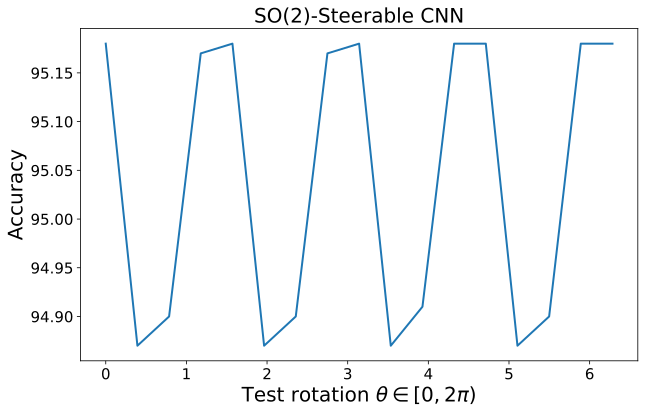

In [ ]:
# plot the accuracy of as a function of the rotation angle theta applied to the test set
fig, ax = plt.subplots(figsize=(10, 6))

N = 16

xs = [i*2*np.pi / N for i in range(N+1)]
plt.plot(xs, accs_so2 + [accs_so2[0]])
plt.title('SO(2)-Steerable CNN', fontsize=20)
plt.xlabel(r'Test rotation $\theta \in [0, 2\pi)$', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

Even after training, the model is not perfectly $SO(2)$ equivariant, but we observe the accuracy is rather stable to rotations.

#### $C_4$ equivariant architecture

For comparison, let's build a similar architecture equivariant only to $N=4$ rotations.

In [ ]:
class CNSteerableCNN(torch.nn.Module):

    def __init__(self, n_classes=10):

        super(CNSteerableCNN, self).__init__()

        # the model is equivariant to rotations by multiples of 2pi/N
        self.r2_act = gspaces.rot2dOnR2(N=4)

        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])

        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type

        # We need to mask the input image since the corners are moved outside the grid under rotations
        self.mask = nn.MaskModule(in_type, 29, margin=1)

        # convolution 1
        # first we build the non-linear layer, which also constructs the right feature type
        # we choose 8 feature fields, each transforming under the regular representation of C_4
        activation1 = nn.ELU(nn.FieldType(self.r2_act, 8*[self.r2_act.regular_repr]), inplace=True)
        out_type = activation1.in_type
        self.block1 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation1,
        )

        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 16 regular feature fields
        activation2 = nn.ELU(nn.FieldType(self.r2_act, 16*[self.r2_act.regular_repr]), inplace=True)
        out_type = activation2.in_type
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation2
        )
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 32 regular feature fields
        activation3 = nn.ELU(nn.FieldType(self.r2_act, 32*[self.r2_act.regular_repr]), inplace=True)
        out_type = activation3.in_type
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation3
        )

        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 32 regular feature fields
        activation4 = nn.ELU(nn.FieldType(self.r2_act, 32*[self.r2_act.regular_repr]), inplace=True)
        out_type = activation4.in_type
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation4
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 64 regular feature fields
        activation5 = nn.ELU(nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr]), inplace=True)
        out_type = activation5.in_type
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation5
        )

        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields
        activation6 = nn.ELU(nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr]), inplace=True)
        out_type = activation6.in_type
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation6
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)

        # number of output invariant channels
        c = 64

        output_invariant_type = nn.FieldType(self.r2_act, c*[self.r2_act.trivial_repr])
        self.invariant_map = nn.R2Conv(out_type, output_invariant_type, kernel_size=1, bias=False)


        # Fully Connected classifier
        self.fully_net = torch.nn.Sequential(
            torch.nn.BatchNorm1d(c),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(c, n_classes),
        )

    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = self.input_type(input)

        # mask out the corners of the input image
        x = self.mask(x)

        # apply each equivariant block

        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # Each layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)

        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)

        x = self.block5(x)
        x = self.block6(x)

        # pool over the spatial dimensions
        x = self.pool3(x)

        # extract invariant features
        x = self.invariant_map(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor

        # classify with the final fully connected layer
        x = self.fully_net(x.reshape(x.shape[0], -1))

        return x

Instantiate and train the $C_4$ equivariant model:

In [ ]:
torch.manual_seed(42)
model_c4 = CNSteerableCNN().to(device)
#train(model_c4, checkpoint_path="steerable_c4-pretrained.ckpt")
train(model_c4)
accuracy = test(model_c4)
print(f"Test accuracy: {accuracy}")

#accs_c4 = test_model_rotations(model_c4, 16, 10000, checkpoint_path="steerable_c4-accuracies.npy")

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 0 | test accuracy: 80.27
epoch 10 | test accuracy: 90.424
epoch 20 | test accuracy: 93.63
Test accuracy: 93.63


In [ ]:
accs_c4 = test_model_rotations(model_c4, 16, 10000)

  0%|          | 0/16 [00:00<?, ?it/s]

Finally, let's compare the performance of both models on the rotated test sets:

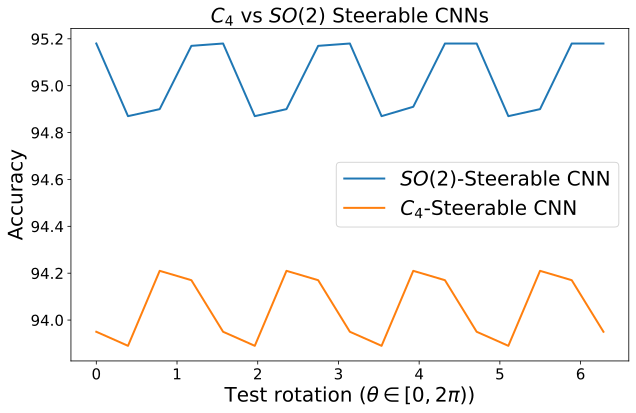

In [ ]:
# plot the accuracy of as a function of the rotation angle theta applied to the test set
fig, ax = plt.subplots(figsize=(10, 6))

N=16

xs = [i*2*np.pi / N for i in range(N+1)]
plt.plot(xs, accs_so2 + [accs_so2[0]], label=r'$SO(2)$-Steerable CNN')
plt.plot(xs, accs_c4 + [accs_c4[0]], label=r'$C_4$-Steerable CNN')
plt.title(r'$C_4$ vs $SO(2)$ Steerable CNNs', fontsize=20)

plt.xlabel(r'Test rotation ($\theta \in [0, 2\pi)$)', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=20)
plt.show()

Reference: GDL-Steerable CNNs by Gabriele Cesa

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Geometric_deep_learning/tutorial2_steerable_cnns.html